In [56]:
import cv2
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
import seaborn as sn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as RF

plt.rcParams['image.cmap'] = 'gray'

In [57]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Manzanas prueba

In [58]:
os.chdir("/content/drive/MyDrive/Proyecto TIMAG")

In [59]:
!ls

Backgrounds	  dataset.zip		       Frutas
clasificador.png  detector.png		       Pruebas_separar.ipynb
dataset		  Entregable3IvanAbatte.ipynb  Untitled0.ipynb


In [60]:
def background(I,Ib):
  return I*np.moveaxis(np.array([Ib,Ib,Ib]),0,-1)

def mean_color(I,Ib):
  bk=I*np.moveaxis(np.array([Ib,Ib,Ib]),0,-1)
  mean=np.sum(bk,axis=(0,1))/np.sum(Ib,axis=(0,1))
  return mean

def filtrar_areas(img,th):
    connectivity = 8
    out = cv2.connectedComponentsWithStats(img, connectivity)
    labels = out[0]
    cc = out[1]
    area = out[2][:,-1]

    for i in range(cc.shape[0]):
        for j in range(cc.shape[1]):
            if cc[i,j] != 0:
                if area[cc[i,j]] < th:
                    cc[i,j] = 0
                else:
                    cc[i,j] = 255
    return np.array(cc/255,np.uint8)
    
def calcular_momento(x,n):
    '''
    Calcula el momento de orden n de la muestra x
    '''
    z=np.arange(len(x))/len(x)
    m=sum(x*z)/len(x)
    
    if n==1:
        return m
    else:
        m_n=sum(((z-m)**n)*x)
    
    return m_n
def entropy(c):
  numBins = 256        #Calculamos el histograma en modo densidad (normalizado)
  histograma, bin_edges = np.histogram(c, np.arange(numBins+1), density=True)
  mean=calcular_momento(histograma,n=1)
  skewness=calcular_momento(histograma,n=3)
  flatness=calcular_momento(histograma,n=4)
  R=1-1/(1+calcular_momento(histograma,n=2))
  uniformity=sum(histograma**2)
  return np.array([mean,skewness,flatness,R,uniformity])

In [61]:
def fill_holes(I):
  im_floodfill = I.copy()
  h, w = I.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);

  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)

  # Combine the two images to get the foreground.
  return I | im_floodfill_inv

In [62]:
frutas=os.listdir("dataset")

In [64]:
def get_features_contours(contours):
  areas=[cv2.contourArea(contour) for contour in contours]
  perimetros=[cv2.arcLength(contour,True) for contour in contours]
  circularidad=[4*np.pi*area/(perimetro**2) for area,perimetro in zip(areas,perimetros)]
  return np.array([min(areas),min(perimetros),max(circularidad),min(circularidad)])

In [66]:
X=[]

plt.figure()

for fruta in frutas:
  for img_path in tqdm(os.listdir(f"dataset/{fruta}/datos")):
     I=cv2.imread(f"dataset/{fruta}/datos/{img_path}")  #Levantamos la imagen
     Iy=cv2.cvtColor(I,cv2.COLOR_BGR2YUV)        #La pasamos a YUV
     u=Iy[...,1]
     v=Iy[...,2]
     _, thru = cv2.threshold(u, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)   #Binarizamos
     _, thrv = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
     ub=u>thru
     vb=v<thrv
     orb=ub+vb                                  #Nos quedamos con el OR
     kernel = np.ones((7,7),np.uint8)
     orb_c=cv2.morphologyEx(np.array(orb,np.uint8), cv2.MORPH_OPEN, kernel)   #Hacemos el OPEN
     orb_c_f=filtrar_areas(orb_c,1000)                   #Filtramos areas
     blur = cv2.blur(orb_c_f,(7,7))                      #Hacemos un blur
     contours, hierarchy =cv2.findContours(fill_holes(blur), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  #Calculamos contornos de la imagen rellena
     contours_features=get_features_contours(contours)   #Sacamos features de los contornos
     mean=mean_color(cv2.cvtColor(I,cv2.COLOR_BGR2RGB),blur)   #Obtenemos color medio
     datos=np.hstack((mean,contours_features))   #Juntamos los datos
     X.append([datos,fruta])
     #cv2.imwrite(f"Backgrounds/{fruta}_{img_path}.png",background(I,blur))

100%|██████████| 63/63 [00:17<00:00,  3.51it/s]


<Figure size 432x288 with 0 Axes>

In [67]:
X_m=np.array([x[0] for x in X])

In [68]:
mapa={'manzanas': 0, 'bananas': 1, 'kiwis': 2, 'mangos': 3, 'naranjas': 4, 'cerezas': 5}
y=np.array([mapa[x[1]] for x in X])

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_m, y, test_size=0.5, random_state=4280)

In [73]:
rf=RF(n_estimators=1000)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [74]:
predicciones=rf.predict(X_val)
acc=sum(predicciones==y_val)/len(y_val)

In [75]:
acc

0.8518518518518519

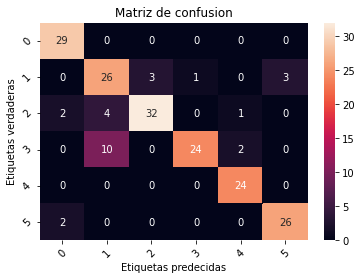

In [76]:
matriz_confusion=confusion_matrix(y_val,predicciones)

plt.figure()
ax= plt.subplot()
sn.heatmap(matriz_confusion, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Etiquetas predecidas')
ax.set_ylabel('Etiquetas verdaderas')
ax.set_title('Matriz de confusion')
ax.xaxis.set_ticklabels(range(6),rotation=45);
ax.yaxis.set_ticklabels(range(6),rotation=45);